<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#View-Baumgartner_C-N.pb-file" data-toc-modified-id="View-Baumgartner_C-N.pb-file-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>View Baumgartner_C-N.pb file</a></span></li><li><span><a href="#Train-ML-model-on-Baumgartner_C-N" data-toc-modified-id="Train-ML-model-on-Baumgartner_C-N-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train ML model on Baumgartner_C-N</a></span><ul class="toc-item"><li><span><a href="#Create-datasets" data-toc-modified-id="Create-datasets-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Create datasets</a></span></li><li><span><a href="#Set-up-model-using-Tensorflow" data-toc-modified-id="Set-up-model-using-Tensorflow-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Set up model using Tensorflow</a></span></li></ul></li><li><span><a href="#Train-Benchmarks" data-toc-modified-id="Train-Benchmarks-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train Benchmarks</a></span><ul class="toc-item"><li><span><a href="#Baumgartner_C-N" data-toc-modified-id="Baumgartner_C-N-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Baumgartner_C-N</a></span><ul class="toc-item"><li><span><a href="#Set-up-domain" data-toc-modified-id="Set-up-domain-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Set up domain</a></span></li><li><span><a href="#Create-Dataset" data-toc-modified-id="Create-Dataset-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Create Dataset</a></span></li><li><span><a href="#Save-and-load-the-benchmark" data-toc-modified-id="Save-and-load-the-benchmark-4.1.3"><span class="toc-item-num">4.1.3&nbsp;&nbsp;</span>Save and load the benchmark</a></span></li></ul></li><li><span><a href="#Ahneman" data-toc-modified-id="Ahneman-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Ahneman</a></span><ul class="toc-item"><li><span><a href="#Set-up-domain" data-toc-modified-id="Set-up-domain-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Set up domain</a></span></li><li><span><a href="#Create-Dataset" data-toc-modified-id="Create-Dataset-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Create Dataset</a></span></li><li><span><a href="#Define-pretraining-Dataset" data-toc-modified-id="Define-pretraining-Dataset-4.2.3"><span class="toc-item-num">4.2.3&nbsp;&nbsp;</span>Define pretraining Dataset</a></span></li></ul></li><li><span><a href="#Buitrago-Santinilla" data-toc-modified-id="Buitrago-Santinilla-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Buitrago-Santinilla</a></span><ul class="toc-item"><li><span><a href="#Define-pretraining-Dataset" data-toc-modified-id="Define-pretraining-Dataset-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>Define pretraining Dataset</a></span></li></ul></li></ul></li><li><span><a href="#Optimisation" data-toc-modified-id="Optimisation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Optimisation</a></span><ul class="toc-item"><li><span><a href="#Learning-how-the-Random-strategy-works" data-toc-modified-id="Learning-how-the-Random-strategy-works-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Learning how the Random strategy works</a></span></li><li><span><a href="#Run-strategies" data-toc-modified-id="Run-strategies-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Run strategies</a></span></li><li><span><a href="#Plot-results" data-toc-modified-id="Plot-results-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Plot results</a></span></li></ul></li></ul></div>

# Imports

In [20]:
# Import modules
import ord_schema
from ord_schema import message_helpers, validations
from ord_schema.proto import dataset_pb2

import math
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
#import wget

from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn import model_selection, metrics
from glob import glob
from IPython.display import clear_output

#summit
import summit
from summit.benchmarks import ExperimentalEmulator
from summit.domain import *
from summit.utils.dataset import DataSet
from summit import Runner
from summit.strategies import Random, SOBO, MultitoSingleObjective, STBO, MTBO
from summit.benchmarks import SnarBenchmark
import pkg_resources
import pathlib


# View Baumgartner_C-N.pb file

In [ ]:
pb = '../data/baumgartner_C-N/baumgartner_C-N.pb'

# Load Dataset message
data = message_helpers.load_message(pb, dataset_pb2.Dataset)

# Ensure dataset validates
valid_output = validations.validate_message(data)

# Convert dataset to pandas dataframe
df = message_helpers.messages_to_dataframe(data.reactions, 
                                           drop_constant_columns=True)

# View dataframe
df

In [ ]:
# Check for NaN values
print(f'number of NaN values: {df.isnull().sum().sum()}')

# Show column counts
df.info()

In [ ]:
# Create new dataframe containing only columns to be used in modeling
model_cols = ['inputs["Catalyst"].components[0].identifiers[0].value',
              'inputs["Base"].components[0].identifiers[0].value',
              'inputs["Solvent"].components[0].identifiers[0].value',
              'inputs["Nucleophile"].components[0].identifiers[0].value',
              'outcomes[0].reaction_time.value',
              'conditions.temperature.setpoint.value',
              'outcomes[0].products[0].measurements[0].percentage.value',
             ]
df = df[model_cols]
df

# Train ML model on Baumgartner_C-N

Following example 'Granda_Perera_ml_example' from ORD example

In [ ]:
# Show dataset statistics for numerical fields
df.describe()

In [ ]:
# Convert reaction input labels to one-hot encoding
input_cols = model_cols[:-1]

# Assign names for each input
prefix = ['catalyst',
          'base',
          'solvent',
          'nucleophile'
]

# Create one-hot encoded input dataset
ohe_df = pd.get_dummies(df[input_cols], prefix=prefix)

# Add yield column to ohe dataset
ohe_df['yield'] = df[model_cols[-1]]/100

# View dataset
ohe_df

## Create datasets

In [ ]:
# Create numpy arrays for inputs and outputs 
X = ohe_df.drop(columns=['yield']).values
y = ohe_df['yield'].values

# Verify array shapes
print(X.shape, y.shape)

In [ ]:
# Set training, validation, and test sets with random_state for reproducibility
_X_train, X_test, _y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.3, random_state=0)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    _X_train, _y_train, test_size=(0.1/0.7), shuffle=False)

# Check lengths
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)
print(len(ohe_df) == X_train.shape[0] + X_valid.shape[0] + X_test.shape[0])

In [ ]:
# Create training, validation, and test sets as tf Datasets and batch
batch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)).batch(batch_size)
valid_dataset = tf.data.Dataset.from_tensor_slices(
    (X_valid, y_valid)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (X_test, y_test)).batch(batch_size)

# Check length (in batches)
print(train_dataset.cardinality().numpy())
print(valid_dataset.cardinality().numpy())
print(test_dataset.cardinality().numpy())

## Set up model using Tensorflow
Using hyperparameters from Granda et al. Nature 2018, 559, 377, DOI: 10.1038/s41586-018-0307-8.

In [ ]:
# Set model parameters
epochs = 300

# Construct model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1]),
    tf.keras.layers.Dense(50, activation='sigmoid'),
    tf.keras.layers.Dense(7, activation='sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1),
])

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(0.005),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Setup callback to load weights from best epoch later on
# Saving model weights from epoch with lowest validation loss
checkpoint_filepath = os.path.join(os.getcwd(), 'saved_model')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# Train model
history = model.fit(train_dataset,
                    epochs=epochs,
                    callbacks=[model_checkpoint_callback],
                    validation_data=valid_dataset)

In [ ]:
# Show best epoch
best_epoch = np.argmin(np.array(history.history['val_loss']))
best_epoch

In [ ]:
# Load model weights from best epoch
model.load_weights(os.path.join(checkpoint_filepath, 'variables/variables'))

# Generate predictions for test set and measure test RMSE and R2
preds = model.predict(test_dataset)
evals = model.evaluate(x=test_dataset, return_dict=True)
r2 = metrics.r2_score(y_test, preds)
rmse = evals['root_mean_squared_error']
print(f'Test RMSE: {evals}')
print(f'Test R2: {r2}')

# Plot model performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
fig.suptitle('Baumgartner C-N HTE MLP Model Performance')

# Plot loss through training
ax1.plot(history.history['loss'], 'b', label='training loss')
ax1.plot(history.history['val_loss'], 'g', label='validation loss')
ax1.legend()
ax1.set_ylabel('loss (MSE)')
ax1.set_xlabel('epoch')
ax1.set_title('loss curves')

# Plot predictions vs ground truth
ax2.plot(y_test, preds, 'bo')
ax2.plot([0, 1], 'r')
ax2.set_ylabel('predicted yield')
ax2.set_xlabel('ground truth yield')
ax2.set_title('predictions vs ground truth')
ax2.text(0.6, 0, f'test_RMSE: {round(rmse, 3)}')
ax2.text(0.6, -0.05, f'test_R2: {round(r2, 3)}')

# View performance plots
plt.show()

In [ ]:
# Show ground truth and predicted yield distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('Ground Truth and Predicted Yield Distributions')

# Plot ground truth histogram
ax1.hist(ohe_df['yield'], bins=20, rwidth=0.93, color='navy')
ax1.set_title('ground truth')
ax1.set_xlabel('yield')
ax1.set_ylabel('frequency (count)')

# Plot predicted histogram
ax2.hist(preds, bins=20, rwidth=0.93, color='navy')
ax2.set_title('predictions')
ax2.set_xlabel('yield')
ax2.set_ylabel('frequency (count)')

# View distributions
plt.show()

# Train Benchmarks
https://gosummit.readthedocs.io/en/latest/tutorials/new_benchmarks.html

## Baumgartner_C-N

### Set up domain

We are going to manipulate:
- Ligand (precatalyst is always the same)
- Nucleophile
- Base
- Solvent
- Temperature
- Reaction time

Objective: Maximise yield

In [30]:
domain = Domain()

# Decision variables
# The precatalyst is always the same: https://www.strem.com/catalog/v/46-0308/51/palladium_225931-80-6
# The additive is always the same: 4-Chlorotoluene
# The ligand changes

des_1 = "Catalyst"
domain += CategoricalVariable(
    name='inputs["Catalyst"].components[0].identifiers[0].value',
    description=des_1,
    levels=[
        'cycloPd tBuXPhos 4-Chlorotoluene', 
         'cycloPd EPhos 4-Chlorotoluene', 
         'cycloPd AlPhos 4-Chlorotoluene', 
         'cycloPd tBuBrettPhos 4-Chlorotoluene',
    ],
)

# Decision variables
des_2 = "Nucleophile"
domain += CategoricalVariable(
    name='inputs["Nucleophile"].components[0].identifiers[0].value',
    description=des_2,
    levels=[
        "Aniline",
        "Benzamide",
        "Phenethylamine",
        "Morpholine",
    ],
)

# Decision variables
des_3 = "Base"
domain += CategoricalVariable(
    name='inputs["Base"].components[0].identifiers[0].value',
    description=des_3,
    levels=[
        "TEA",
        "Triethylamine",
        "TMG",
        "BTMG",
        "DBU",
        "MTBD",
        "BTTP",
        "P2Et",
    ],
)

# Decision variables
des_4 = "Solvent"
domain += CategoricalVariable(
    name='inputs["Solvent"].components[0].identifiers[0].value',
    description=des_4,
    levels=[
        "2-MeTHF",
        "DMSO",
    ],
)

des_5 = "Residence time in seconds (s)"
domain += ContinuousVariable(name="outcomes[0].reaction_time.value", description=des_5, bounds=[60, 6000])

des_6 = "Reactor temperature in degrees Celsius (ºC)"
domain += ContinuousVariable(
    name="conditions.temperature.setpoint.value", description=des_6, bounds=[30, 110]
)


# Objectives
des_7 = "Yield"
domain += ContinuousVariable(
    name="outcomes[0].products[0].measurements[0].percentage.value",
    description=des_5,
    bounds=[0, 105],
    is_objective=True,
    maximize=True,
)

In [31]:
domain

Name,Type,Description,Values
"inputs[""Catalyst""].components[0].identifiers[0].value","categorical, input",Catalyst,4 levels
"inputs[""Nucleophile""].components[0].identifiers[0].value","categorical, input",Nucleophile,4 levels
"inputs[""Base""].components[0].identifiers[0].value","categorical, input",Base,8 levels
"inputs[""Solvent""].components[0].identifiers[0].value","categorical, input",Solvent,2 levels
outcomes[0].reaction_time.value,"continuous, input",Residence time in seconds (s),"[60,6000]"
conditions.temperature.setpoint.value,"continuous, input",Reactor temperature in degrees Celsius (ºC),"[30,110]"
outcomes[0].products[0].measurements[0].percentage.value,"continuous, maximize objective",Residence time in seconds (s),"[0,105]"


### Create Dataset

In [ ]:
# shuffle df
df_shuffle = df.sample(frac=1)
baumgartner_cn_ds = DataSet.from_df(df_shuffle)

In [ ]:
# train benchmark
baumgartner_cn = ExperimentalEmulator(model_name='baumgartner_cn', domain=domain, dataset=baumgartner_cn_ds)
baumgartner_cn.train(max_epochs=1000, cv_fold=2, test_size=0.1, verbose=1)

#Parity plot
fig, ax = baumgartner_cn.parity_plot(include_test=True)

In [ ]:
#Test out a set of conditions on the benchmark
conditions = [["cycloPd EPhos 4-Chlorotoluene",'Aniline', 'BTMG', '2-MeTHF', 1324, 65.0]]
conditions = DataSet(conditions, columns=[v.name for v in domain.input_variables])
baumgartner_cn.run_experiments(conditions)

### Save and load the benchmark

In [ ]:
# Save it
baumgartner_cn.save(save_dir="/Users/dsw46/OneDrive - University of Cambridge/Cambridge\
/Projects/multitask/multitask/data/baumgartner_C-N/baumgartner_C-N_emulator")

In [22]:
# Load it
baumgartner_cn = ExperimentalEmulator.load(model_name="baumgartner_cn", save_dir="../data/baumgartner_C-N/baumgartner_C-N_emulator")

## Ahneman

In [3]:
pb = '../data/Ahneman/ord/ahneman.pb'

# Load Dataset message
data = message_helpers.load_message(pb, dataset_pb2.Dataset)

# Ensure dataset validates
valid_output = validations.validate_message(data)

# Convert dataset to pandas dataframe
ahneman_df = message_helpers.messages_to_dataframe(data.reactions, 
                                           drop_constant_columns=True)

# View dataframe
ahneman_df

,"inputs[""catalyst""].components[0].identifiers[0].value","inputs[""catalyst""].components[0].identifiers[1].value","inputs[""additive""].components[0].identifiers[0].type","inputs[""additive""].components[0].identifiers[0].value","inputs[""additive""].components[0].identifiers[1].type","inputs[""additive""].components[0].identifiers[1].value","inputs[""additive""].components[0].amount.volume.value","inputs[""additive""].components[0].amount.volume.units","inputs[""additive""].components[0].amount.volume_includes_solutes","inputs[""additive""].components[0].reaction_role",...,"inputs[""additive""].components[1].identifiers[0].type","inputs[""additive""].components[1].identifiers[0].value","inputs[""additive""].components[1].identifiers[1].type","inputs[""additive""].components[1].identifiers[1].value","inputs[""additive""].components[1].amount.volume.value","inputs[""additive""].components[1].amount.volume.units","inputs[""additive""].components[1].amount.volume_includes_solutes","inputs[""additive""].components[1].reaction_role","inputs[""additive""].components[1].preparations[0].type","inputs[""additive""].components[1].source.vendor"
0,XPhos,CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)(C2CCCCC...,NAME,DMSO,SMILES,CS(=O)C,0.2,MICROLITER,True,SOLVENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,XPhos,CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)(C2CCCCC...,NAME,DMSO,SMILES,CS(=O)C,0.2,MICROLITER,True,SOLVENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,XPhos,CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)(C2CCCCC...,NAME,DMSO,SMILES,CS(=O)C,0.2,MICROLITER,True,SOLVENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,XPhos,CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)(C2CCCCC...,NAME,DMSO,SMILES,CS(=O)C,0.2,MICROLITER,True,SOLVENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,XPhos,CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)(C2CCCCC...,NAME,DMSO,SMILES,CS(=O)C,0.2,MICROLITER,True,SOLVENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4307,AdBrettPhos,COc1ccc(OC)c(P(C23CC4CC(CC(C4)C2)C3)(C23CC4CC(...,SMILES,COC(=O)c1cc(-c2cccs2)on1,NaN,NaN,NaN,NaN,NaN,REAGENT,...,NAME,DMSO,SMILES,CS(=O)C,0.2,MICROLITER,True,SOLVENT,NONE,Aldrich
4308,AdBrettPhos,COc1ccc(OC)c(P(C23CC4CC(CC(C4)C2)C3)(C23CC4CC(...,SMILES,COC(=O)c1cc(-c2cccs2)on1,NaN,NaN,NaN,NaN,NaN,REAGENT,...,NAME,DMSO,SMILES,CS(=O)C,0.2,MICROLITER,True,SOLVENT,NONE,Aldrich
4309,AdBrettPhos,COc1ccc(OC)c(P(C23CC4CC(CC(C4)C2)C3)(C23CC4CC(...,SMILES,COC(=O)c1cc(-c2cccs2)on1,NaN,NaN,NaN,NaN,NaN,REAGENT,...,NAME,DMSO,SMILES,CS(=O)C,0.2,MICROLITER,True,SOLVENT,NONE,Aldrich
4310,AdBrettPhos,COc1ccc(OC)c(P(C23CC4CC(CC(C4)C2)C3)(C23CC4CC(...,SMILES,COC(=O)c1cc(-c2cccs2)on1,NaN,NaN,NaN,NaN,NaN,REAGENT,...,NAME,DMSO,SMILES,CS(=O)C,0.2,MICROLITER,True,SOLVENT,NONE,Aldrich


In [6]:
# Check for NaN values
print(f'number of NaN values: {ahneman_df.isnull().sum().sum()}')

# Show column counts
ahneman_df.info()

number of NaN values: 26952
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4312 entries, 0 to 4311
Data columns (total 32 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   inputs["catalyst"].components[0].identifiers[0].value            4312 non-null   object 
 1   inputs["catalyst"].components[0].identifiers[1].value            4312 non-null   object 
 2   inputs["additive"].components[0].identifiers[0].type             4312 non-null   object 
 3   inputs["additive"].components[0].identifiers[0].value            4312 non-null   object 
 4   inputs["additive"].components[0].identifiers[1].type             180 non-null    object 
 5   inputs["additive"].components[0].identifiers[1].value            180 non-null    object 
 6   inputs["additive"].components[0].amount.volume.value             180 non-null    float64
 7   inputs["additi

In [7]:
# Create new dataframe containing only columns to be used in modeling
model_cols = ['inputs["catalyst"].components[0].identifiers[0].value',
              'inputs["base"].components[0].identifiers[0].value',
              'inputs["aryl halide"].components[0].identifiers[0].value',
              'inputs["additive"].components[0].identifiers[0].value',
              'inputs["additive"].components[1].identifiers[0].value',
              'outcomes[0].products[0].measurements[0].percentage.value',
             ]
ahneman_df = ahneman_df[model_cols]
ahneman_df

,"inputs[""catalyst""].components[0].identifiers[0].value","inputs[""base""].components[0].identifiers[0].value","inputs[""aryl halide""].components[0].identifiers[0].value","inputs[""additive""].components[0].identifiers[0].value","inputs[""additive""].components[1].identifiers[0].value",outcomes[0].products[0].measurements[0].percentage.value
0,XPhos,P2Et,FC(F)(F)c1ccc(Cl)cc1,DMSO,NaN,26.888615
1,XPhos,P2Et,FC(F)(F)c1ccc(Br)cc1,DMSO,NaN,24.063225
2,XPhos,P2Et,FC(F)(F)c1ccc(I)cc1,DMSO,NaN,47.515820
3,XPhos,P2Et,COc1ccc(Cl)cc1,DMSO,NaN,2.126831
4,XPhos,P2Et,COc1ccc(Br)cc1,DMSO,NaN,47.586353
...,...,...,...,...,...,...
4307,AdBrettPhos,MTBD,Brc1ccccn1,COC(=O)c1cc(-c2cccs2)on1,DMSO,57.426670
4308,AdBrettPhos,MTBD,Ic1ccccn1,COC(=O)c1cc(-c2cccs2)on1,DMSO,86.233154
4309,AdBrettPhos,MTBD,Clc1cccnc1,COC(=O)c1cc(-c2cccs2)on1,DMSO,1.440081
4310,AdBrettPhos,MTBD,Brc1cccnc1,COC(=O)c1cc(-c2cccs2)on1,DMSO,43.538364


In [ ]:
cat = set(ahneman_df[model_cols[0]])
print('Catalysts: ',cat)
base = set(ahneman_df[model_cols[1]])
print('Bases: ',base)
aryl_halides = set(ahneman_df[model_cols[2]])
print('Aryl halides: ',aryl_halides)
solvent_0 = set(ahneman_df[model_cols[3]])
print('Solvent 0: ',solvent_0)
solvent_1 = set(ahneman_df[model_cols[4]])
print('Solvent 1: ',solvent_1)


In [ ]:
set(df['inputs["additive"].components[0].amount.moles.value'])

### Set up domain

In [ ]:
ahneman_domain = Domain()

# Decision variables

des_1 = "Catalyst"
ahneman_domain += CategoricalVariable(
    name='inputs["Catalyst"].components[0].identifiers[0].value',
    description=des_1,
    levels=[
    'AdBrettPhos', 'XPhos', 
    't-BuBrettPhos', 't-BuXPhos',
    ],
)

# Decision variables
des_2 = "Base"
ahneman_domain += CategoricalVariable(
    name='inputs["Base"].components[0].identifiers[0].value',
    description=des_2,
    levels=[
    'P2Et', 'BTMG', 
    'MTBD',
    ],
)

# Decision variables
des_3 = "aryl_halide"
ahneman_domain += CategoricalVariable(
    name='inputs["Nucleophile"].components[0].identifiers[0].value',
    description=des_3,
    levels=[
    'FC(F)(F)c1ccc(Cl)cc1', 'FC(F)(F)c1ccc(Br)cc1', 'COc1ccc(Cl)cc1', 
    'Brc1cccnc1', 'Ic1ccccn1', 'COc1ccc(Br)cc1', 'CCc1ccc(I)cc1', 'Brc1ccccn1', 
    'Clc1ccccn1', 'Ic1cccnc1', 'Clc1cccnc1', 'COc1ccc(I)cc1', 
    'FC(F)(F)c1ccc(I)cc1', 'CCc1ccc(Br)cc1', 'CCc1ccc(Cl)cc1',
    ],
)

# Decision variables
des_4 = "Solvent_0"
ahneman_domain += CategoricalVariable(
    name='inputs["Solvent"].components[0].identifiers[0].value',
    description=des_4,
    levels=[
    'Cc1ccon1', 'Fc1cccc(F)c1-c1ccno1', 'c1ccc(-c2cnoc2)cc1',
    'CCOC(=O)c1cc(C)no1', 'c1ccc(CN(Cc2ccccc2)c2ccon2)cc1', 
    'Cc1cc(C)on1', 'CCOC(=O)c1ccon1', 'CCOC(=O)c1cnoc1C', 
    'c1ccc2nocc2c1', 'COC(=O)c1ccno1', 'CCOC(=O)c1cc(OC)no1', 
    'c1ccc(-c2ccno2)cc1', 'c1ccc(CN(Cc2ccccc2)c2ccno2)cc1',
    'c1ccc(-c2ccon2)cc1', 'Cc1cc(-c2ccccc2)on1', 
    'c1ccc2oncc2c1', 'Cc1ccno1', 'COC(=O)c1cc(-c2cccs2)on1', 
    'COC(=O)c1cc(-c2ccco2)on1', 'CCOC(=O)c1cc(C)on1', 
    'Cc1cc(-n2cccc2)no1', 'c1ccc(-c2ncno2)cc1', 
    'DMSO', 'CCOC(=O)c1cnoc1'
    ],
)

# Decision variables
des_5 = "Solvent_1"
ahneman_domain += CategoricalVariable(
    name='inputs["Solvent"].components[0].identifiers[0].value',
    description=des_5,
    levels=[
    'NaN', 'DMSO'
    ],
)


# Objectives
des_7 = "Yield"
ahneman_domain += ContinuousVariable(
    name="outcomes[0].products[0].measurements[0].percentage.value",
    description=des_5,
    bounds=[0, 100],
    is_objective=True,
    maximize=True,
)

### Create Dataset

In [ ]:
# shuffle df
df_shuffle = ahneman_df.sample(frac=1)
ahneman_cn_ds = DataSet.from_df(df_shuffle)

In [ ]:
# train benchmark
ahneman_cn = ExperimentalEmulator(model_name='ahneman_cn', domain=ahneman_domain, dataset=ahneman_cn_ds)
ahneman_cn.train(max_epochs=1000, cv_fold=2, test_size=0.1, verbose=1)

#Parity plot
fig, ax = ahneman_cn.parity_plot(include_test=True)

In [ ]:
#Test out a set of conditions on the benchmark
conditions = [["cycloPd EPhos 4-Chlorotoluene",'Aniline', 'BTMG', '2-MeTHF', 1324, 65.0]]
conditions = DataSet(conditions, columns=[v.name for v in domain.input_variables])
baumgartner_cn.run_experiments(conditions)

### Define pretraining Dataset

In [10]:
# shuffle df
df_shuffle = ahneman_df.sample(frac=1)
ahneman_cn_ds = DataSet.from_df(df_shuffle)

## Buitrago-Santinilla

In [ ]:
pb = '../data/Buitrago-Santinilla/ord/Buitrago-Santinilla.pb'

# Load Dataset message
data = message_helpers.load_message(pb, dataset_pb2.Dataset)

# Ensure dataset validates
valid_output = validations.validate_message(data)

# Convert dataset to pandas dataframe
df = message_helpers.messages_to_dataframe(data.reactions, 
                                           drop_constant_columns=True)

# View dataframe
df

In [ ]:
df.describe()

In [ ]:
# Check for NaN values
print(f'number of NaN values: {df.isnull().sum().sum()}')

# Show column counts
df.info()

In [ ]:
# Create new dataframe containing only columns to be used in modeling
model_cols = ['inputs["catalyst"].components[0].identifiers[0].value',
              'inputs["nucleophile"].components[0].identifiers[0].value',
              'inputs["base"].components[0].identifiers[0].value',
              'outcomes[0].products[0].measurements[0].percentage.value',
             ]
Buitrago_df = df[model_cols]
Buitrago_df

### Define pretraining Dataset

In [ ]:
Buitrago_df

In [ ]:
# Get pretraining data
exp_pt = MIT_case1(noise_level=1)
lhs = LHS(exp_pt.domain)
conditions = lhs.suggest_experiments(10)
pt_data = exp_pt.run_experiments((conditions))
pt_data[("task", "METADATA")] = 0
# Use MTBO on a new mechanism
exp = MIT_case2(noise_level=1)
strategy = MTBO(exp.domain,pretraining_data=pt_data, categorical_method="one-hot",task=1)
r = Runner(strategy=strategy, experiment=exp, max_iterations=2)
r.run(progress_bar=False)

# Optimisation

## Learning how the Random strategy works

In [23]:
#Set up the experiment
exp = baumgartner_cn
exp.reset()
# Instantiate random sampling strategy
strategy = Random(exp.domain)

# Use the runner to run closed loop optimisation
r = Runner(strategy=strategy, experiment=exp, max_iterations=50)
r.run()


NameError: name 'CN_benchmark' is not defined

In [ ]:
r.experiment.data

In [ ]:
random_yield = r.experiment.data['outcomes[0].products[0].measurements[0].percentage.value']
plt.plot(random_yield)

In [ ]:
random_yield_max = []
for i in range(len(random_yield)):
    if i == 0:
        j = random_yield[i]
    else:
        j = max(random_yield[i],random_yield_max[i-1])
    random_yield_max+=[j]

In [ ]:
plt.plot(random_yield_max)

In [ ]:
type(exp.domain['inputs["Base"].components[0].identifiers[0].value'].levels[0])

In [ ]:
exp.domain.num_continuous_dimensions()

In [ ]:
#Set up the experiment
exp.reset()
exp = CN_benchmark

# Instantiate sampling strategy
strategy = SOBO(exp.domain)

# Use the runner to run closed loop optimisation
r = Runner(strategy=strategy, experiment=exp, max_iterations=50)
r.run()


In [ ]:
SOBO_yield = r.experiment.data['outcomes[0].products[0].measurements[0].percentage.value']
plt.plot(SOBO_yield)

In [ ]:
SOBO_yield_max = []
for i in range(len(SOBO_yield)):
    if i == 0:
        j = SOBO_yield[i]
    else:
        j = max(SOBO_yield[i],SOBO_yield_max[i-1])
    SOBO_yield_max+=[j]
plt.plot(random_yield_max)

## Run strategies
- Random strategy
- SOBO: Single Objective Bayesian Optimisation
- STBO: Single Task Bayesian Optimisation
- MTBO: Multitask Bayesian Optimisation

In [24]:
def run_random(exp, max_iterations=10, random_state=np.random.RandomState(3)):
    exp.reset()
    strategy = Random(exp.domain, 
                    random_state=random_state)
    r = summit.Runner(strategy=strategy, 
                      experiment=exp, 
                      max_iterations=max_iterations)
    r.run()
    return r

def run_sobo(exp, max_iterations=10, categorical_method="one-hot"):
    exp.reset()
    strategy = SOBO(exp.domain, 
                    categorical_method=categorical_method)
    r = summit.Runner(strategy=strategy, 
                      experiment=exp, 
                      max_iterations=max_iterations)
    r.run()
    return r

def run_mtbo(exp, pt_data, max_iterations=10, task=1):
    strategy = MTBO(exp.domain, 
                    pretraining_data=pt_data,
                    categorical_method="one-hot", 
                    task=task)
    r = summit.Runner(strategy=strategy,
                      experiment=exp, 
                      max_iterations=max_iterations)
    r.run()
    return r

def make_average_plot(results: [summit.Runner], ax, label=None, color=None):
    objective = results[0].experiment.domain.output_variables[0].name
    yields = [r.experiment.data[objective] for r in results]
    yields = np.array(yields)
    mean_yield = np.mean(yields, axis=0)
    std_yield = np.std(yields, axis=0)
    x = np.arange(0, len(mean_yield), 1).astype(int)
    ax.plot(x, mean_yield, label=label, linewidth=2, color=color)
    ax.fill_between(x, mean_yield-std_yield, mean_yield+std_yield, alpha=0.1, color=color)

def make_comparison_plot(*args):
    fig, ax = plt.subplots(1)
    for arg in args:
        make_average_plot(arg['results'], ax, label=arg["label"], color=arg["color"])
    fontdict = fontdict={"size":12}
    ax.legend(loc = "lower right", prop=fontdict)
    ax.set_xlim(0,20)
    ax.set_xticks(np.arange(0, 20, 2).astype(int))
    ax.set_ylabel('Yield', fontdict=fontdict)
    ax.set_xlabel('Reactions', fontdict=fontdict)
    ax.tick_params(direction='in')
    return fig, ax

In [26]:
N_REPEATS = 10
MAX_ITERATIONS = 20

In [27]:
#Random
for i in range(N_REPEATS):
    print(f"Repeat {i}")
    exp = baumgartner_cn
    result = run_random(exp, max_iterations=MAX_ITERATIONS)
    result.save(f"../data/baumgartner_C-N/results/random_{i}.json")
    clear_output(wait=True)

Repeat 9


In [28]:
#Single-Objective Bayesian Optimization
for i in range(N_REPEATS):
    print(f"Repeat {i}")
    exp = baumgartner_cn
    result = run_sobo(exp, max_iterations=MAX_ITERATIONS)
    result.save(f"../data/baumgartner_C-N/results/SOBO_{i}.json")
    clear_output(wait=True)

Repeat 9


In [19]:
#Multi-Task Bayesian Optimization
for i in range(N_REPEATS):
    print(f"Repeat {i}")
    exp = baumgartner_cn
    result = run_mtbo(exp, ahneman_cn_ds, max_iterations=MAX_ITERATIONS)
    result.save(f"../data/baumgartner_C-N/results/MTBO_{i}.json")
    clear_output(wait=True)


Repeat 0


UnboundLocalError: local variable 'samples' referenced before assignment

## Plot results

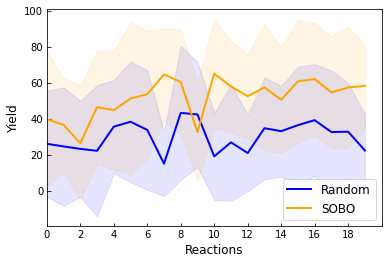

In [29]:
random_results = [summit.Runner.load(f"../data/baumgartner_C-N/results/random_{i}.json") for i in range(10)]
sobo_results = [summit.Runner.load(f"../data/baumgartner_C-N/results/SOBO_{i}.json") for i in range(10)]
#mtbo_results_lists = [[summit.Runner.load(f"data/kinetics_similar/mtbo_case1-2_noise_{n}-pre-train_repeat_{i}.json") 
#                      for i in range(10)]
#                      for n in n_aux]
#

fig, ax = make_comparison_plot(
    dict(results=random_results, label="Random", color = 'blue'),
    dict(results=sobo_results, label="SOBO", color = 'orange'),
#     dict(results=mtbo_results_lists[0],label="MTBO, n=5"),
#    dict(results=mtbo_results_lists[1],label="MTBO, n=10"),
#    dict(results=mtbo_results_lists[2],label="MTBO, n=50")
)
#fig.savefig("figures/stbo_mtbo_kinetics_case1-2_noise_comparison.png", bbox_inches='tight', dpi=300)